In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy
from z3 import *

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/01/20180102_sudoku.png" width="450">

In [32]:
# 50 mins with my numba enhanced backtracking
# less than 2 secs with z3 !

# Setup the constraints
fixed = np.array([[ 0, 0, 9, 0, 0, 9,49, 0, 0],
                  [ 9, 0,25, 0, 0, 0,36, 0, 0],
                  [49, 0, 0,36,16, 9, 0,81,25],
                  [ 4,49, 0, 1, 0, 0, 9, 0,81],
                  [ 0, 0,81, 0, 0, 0,16, 0, 0],
                  [ 9, 0,64, 0, 0, 4, 0, 4, 6],
                  [36,16, 0,16, 4,25, 0, 0,49],
                  [ 0, 0,49, 0, 0, 0, 9, 0, 4],
                  [ 0, 0,36,49, 0, 0,16, 0, 0]],dtype=int)

In [39]:
    def score(solution):
        return  np.sum((solution[fixed!=0]**2))
    
    def sol_print(solution):
        x= np.ones((3,3))
        groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
        fig,ax = plt.subplots(1,2,figsize=(6,3))
        count = 0
        x = np.array(solution.astype('int').astype('str'))
        x[x=="0"] ="-"
        y = (fixed > 0) + groups*2
        ax[0] = sns.heatmap(y,annot=x,cbar=False,cmap="tab20",fmt="",vmin=0,vmax=19,linewidths=1,annot_kws={"size":14},ax=ax[0])
        ax[0].axis("off")
        x1 = np.array(fixed.astype('int').astype('str'))
        x1[x1=="0"] ="-"
        y1 = (fixed > 0) 
        
        ax[1] = sns.heatmap(y1,annot=x1,cbar=False,cmap="Greys",fmt="",vmin=0,vmax=5,linewidths=1,annot_kws={"size":14},ax=ax[1])
        ax[1].axis("off")
        plt.tight_layout()
        plt.show()

In [40]:
def z3_sudoku(grid,fixed):
    start = time.time()
    # 9x9 matrix of integer variables
    X = [ [Int("x_%s_%s" % (i+1, j+1)) for j in range(9) ]  for i in range(9) ]

    # each cell contains a value in {1, ..., 9}
    cells_c  = [ And(1 <= X[i][j], X[i][j] <= 9)
             for i in range(9) for j in range(9) ]

    # each row contains a digit at most once
    rows_c   = [ Distinct(X[i]) for i in range(9) ]

    # each column contains a digit at most once
    cols_c   = [ Distinct([ X[i][j] for i in range(9) ])
             for j in range(9) ]

    # each 3x3 square contains a digit at most once
    sq_c     = [ Distinct([ X[3*i0 + i][3*j0 + j]
                        for i in range(3) for j in range(3) ])
             for i0 in range(3) for j0 in range(3) ]

    sudoku_c = cells_c + rows_c + cols_c + sq_c

    s = Solver()
    s.add(sudoku_c)

    for i,j in itertools.product(range(9),range(9)):
        num =int(fixed[i,j])
        
        if fixed[i,j] == 0:
            continue
        if i == 0:
            s.add(Or(X[i][j-1]*X[i+1][j] == num,
                     X[i][j+1]*X[i+1][j] == num,
                     X[i][j-1]*X[i][j+1] == num))

            continue
        if i == 8:
            s.add(Or(X[i][j-1]*X[i-1][j] == num,
                     X[i][j+1]*X[i-1][j] == num,
                     X[i][j+1]*X[i][j-1] == num))

            continue
        if j == 0:
            s.add(Or(X[i-1][j]*X[i][j+1] == num,
                     X[i+1][j]*X[i][j+1] == num,
                     X[i-1][j]*X[i+1][j] == num))
            continue
        if j == 8:
            s.add(Or(X[i-1][j]*X[i][j-1] == num,
                     X[i+1][j]*X[i][j-1] == num,
                     X[i-1][j]*X[i+1][j] == num))
            continue
    
      
        s.add(Or(X[i-1][j]*X[i][j+1] == num,
                 X[i-1][j]*X[i+1][j] == num,
                 X[i-1][j]*X[i][j-1] == num,
                 X[i][j+1]*X[i+1][j] == num,
                 X[i][j+1]*X[i][j-1] == num,
                 X[i+1][j]*X[i][j-1] == num))
                 
    
    if s.check() == sat:
        m = s.model()
        r = [ [ m.evaluate(X[i][j]).as_long() for j in range(9) ]
                 for i in range(9) ]
        print("Solved in {} seconds".format(time.time()-start))
        print("\nThe product is : {:,.0f}".format(score(np.array(r))))
        sol_print(np.array(r))


    else:
        print("Failed in {} seconds".format(time.time()-start))


Solved in 1.7194299697875977 seconds

The product is : 1,146


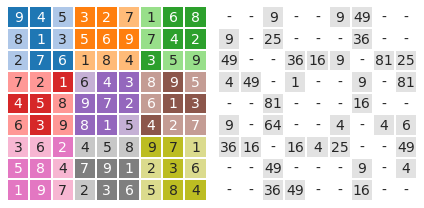

In [41]:
z3_sudoku(np.zeros((9,9)),fixed)


In [42]:
url='https://www.janestreet.com/puzzles/solutions/january-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The completed grid is shown to the left, and the sum of the squares of the numbers written over the grey clue values is 1146 .


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/02/20180201_sudoku_ans.png" width="250" >

In [38]:
correct= np.array([[9,4,5,3,2,7,1,6,8],
                   [8,1,3,5,6,9,7,4,2],
                   [2,7,6,1,8,4,3,5,9],
                   [7,2,1,6,4,3,8,9,5],
                   [4,5,8,9,7,2,6,1,3],
                   [6,3,9,8,1,5,4,2,7],
                   [3,6,2,4,5,8,9,7,1],
                   [5,8,4,7,9,1,2,3,6],
                   [1,9,7,2,3,6,5,8,4]] 
                  ,dtype=int)